# Project 3:

**We start by importing packages that we need**

In [287]:
import numpy as np
import matplotlib.pyplot as plt 
from numba import jit, njit, vectorize, prange
import numba as numba
import time
from scipy.special import gamma, factorial
import math

**Next we define the functions that we need:**

**First the functions for Gauss Quadrature using Legendre polynonials:**

In [3]:
#Legendre is a function that calculates the value of a n-th Legendre polynomial using the recursion relation 
#for Legendre polynomials
@jit()
def Legendre(n,x):
    L_0 = 1
    L_1 = x
    j = 1
    while j < n:#Calculate the value of a second or higher order Legendre polynomial for a given x
        L_2 = (((2*j + 1)/(j + 1)))*x*L_1 - (j/(j + 1))*L_0
        temp = L_1
        L_1 = L_2
        L_0 = temp
        j += 1
        
    if n == 0:
        return L_0
    elif n == 1:
        return L_1
    else:
        return L_2

#Gauss_Legendre is a function that integrates a function f(x) using Legendre polynomials
#def Gauss_Legendre(N,a,b):
    #approximate the function as a polynomial of degree 2N - 1
    #The mesh points are the zeros of L_N(x) - Legendre polynomial of degree N

In [289]:
#Function that sets up the integration and weights for N number of integration points on the interval [-1,1]
@jit()
def GaussLegendre(N):#Sets up the integration points and weights for limit -1 to 1
    #N - number of integration points, [a,b] - integration limits, func - function to be integrated
    L = np.zeros((N,N))#setting up matrix L
    polynomial = np.zeros(N+1)#setting up the N-th Legendre polynomial
    polynomial[N] = 1
    roots = np.polynomial.legendre.legroots(polynomial)#finding the roots of that polynomial
    for i in range(N):#setting up all matrix elements
        for j in range(N):
            L[i,j] = Legendre(j,roots[i])
            
    #finding the inverse
    L_inv = np.linalg.inv(L)
    weights = np.zeros(N)#the weights
    for i in range(N):
        weights[i] = 2*L_inv[0,i]
    
    return roots, weights

#Gauss Legendre in 1 dimension - unused here but coded for implentiation first time
def GaussLegendreIntegrate(roots,weights,func):
    N = len(roots)
    #funtion that use Gauss legendre to numercally integrate
    Integral = 0
    for i in range(N):
        Integral += weights[i]*func(roots[i])
    
    return Integral

In [291]:
#Function that specifies the Integrand in cartesian coordinates
@jit(nopython=True)
def WaveFunctionPos(x1,y1,z1,x2,y2,z2):
    #checking if we are dividing by zero and if so disregard this contribution
    if np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2) < 10e-8:
        return 0
    else:
        return np.exp(-4*(np.sqrt(x1**2+y1**2+z1**2) + np.sqrt(x2**2+y2**2+z2**2)))*(1/(np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)))

@jit()
#This is the function which takes in the integration points and weight on [-1,1] and calculates
#the two electron correlation energy and an interval [a,b]
def GaussLegendreWaveFunc(N,WaveFunction,a,b,intPoints,weights):
    #intPoints, weights = GaussLegendre(N)
    intPoints = ((b-a)/2)*intPoints + (b+a)/2
    #print(weights)
    Integral = 0
    for x1 in range(N):
        for y1 in range(N):
            for z1 in range(N):
                for x2 in range(N):
                    for y2 in range(N):
                        for z2 in range(N):
                            functionValue = WaveFunction(intPoints[x1],intPoints[y1],intPoints[z1],intPoints[x2],intPoints[y2],intPoints[z2])
                            if functionValue < 0:
                                print("Obs")
                            Integral += weights[x1]*weights[y1]*weights[z1]*weights[x2]*weights[y2]*weights[z2]*functionValue
                            
                            
    Integral = Integral*(((b-a)/2)**6)
    return Integral

**Next are the functions needed for Gaussian Quadrature using Laguerre polynomials:**

In [59]:
#Recursion formula for the n-th Laguerre polynomial
@jit(nopython=True)
def Laguerre(n,x):#n-th Laguerre polynomial at position x
    L_0 = 1
    L_1 = 1-x
    j = 1
    while j < n:
        L_2 = (2*j + 1 - x)*L_1 - j*L_0
        L_2 = L_2/(j + 1)
        temp = L_1
        L_1 = L_2
        L_0 = temp
        j += 1
        
    return L_2

In [195]:
#Roots of the n-th order Laguerre polynomial
@jit()
def LaguerreRoots(n):#roots of n-th order Laguerre polynomial
    polynomial = np.zeros(n+1)
    polynomial[n] = 1
    #print(polynomial)
    roots = np.polynomial.laguerre.lagroots(polynomial)
    return roots

#Weights for using Laguerre polynomials
@jit()
def LaguerreWeights(roots,n):
    weights = np.zeros(len(roots))
    for i in range(len(roots)):
        weights[i] = roots[i]/(((n+1)**2)*(Laguerre(n+1,roots[i])**2))
    return weights

#Wave function integrand in polar coordinates and taking into account the use of Laguerre polynomials
@jit(nopython=True)
def WaveFuncPolar(r1,r2,theta1,theta2,phi1,phi2):
    cosBeta = np.cos(theta1)*np.cos(theta2) + np.sin(theta1)*np.sin(theta2)*np.cos(phi1-phi2)
    if abs(r1**2 + r2**2 - 2*r1*r2*cosBeta) < 10e-10:#to account for zero and loss on numerical precession
        return 0
    else:
        r_12 = np.sqrt(r1**2 + r2**2 - 2*r1*r2*cosBeta)
        return (r1**2)*(r2**2)*np.sin(theta1)*np.sin(theta2)*np.exp(-3*(r1 + r2))*(1/r_12)
    
#Wave function integrand in polar coordinates for Monte Carlo integration, importance sampling
@jit(nopython=True)
def WaveFuncPolarMC(r1,r2,theta1,theta2,phi1,phi2):
    cosBeta = np.cos(theta1)*np.cos(theta2) + np.sin(theta1)*np.sin(theta2)*np.cos(phi1-phi2)
    if abs(r1**2 + r2**2 - 2*r1*r2*cosBeta) < 10e-10:#to account for zero and loss on numerical precession
        return 0
    else:
        r_12 = np.sqrt(r1**2 + r2**2 - 2*r1*r2*cosBeta)
        return (r1**2)*(r2**2)*np.exp(-3*(r1+r2))*np.sin(theta1)*np.sin(theta2)*(1/r_12)

**Integration using Legendre polynomials for the angles and Laguerre polynomials for the radial part:**

In [292]:
#Function the computes the correlation energy for the two electrons using Legendre polynomials for the 
#angles and Laguerre polynomials for the radial part
@jit(nopython=True)
def ImprovedGauss(N,WaveFuncPolar,intPointsTheta,intPointsPhi,intPointsR,weightsTheta,weightsPhi,weightsR,a1,b1,a2,b2):
    Integral2 = 0
    for theta1 in range(N):
            for theta2 in range(N):
                for phi1 in range(N):
                    for phi2 in range(N):
                        for r1 in range(N):
                            for r2 in range(N):
                                functionValue = WaveFuncPolar(intPointsR[r1],intPointsR[r2],intPointsTheta[theta1],intPointsTheta[theta2],intPointsPhi[phi1],intPointsPhi[phi2])
                                Integral2 += weightsTheta[theta1]*weightsTheta[theta2]*weightsPhi[phi1]*weightsPhi[phi2]*weightsR[r1]*weightsR[r2]*functionValue
                            
    Integral2 = Integral2*(((b1-a1)/2)**2)*(((b2-a2)/2)**2)
    return Integral2

## Gauss Legendre

Let's start finding where the wave function as approximately zero so that we can discretize and find an approximation for infinity. To do so we plot the wave function for a single particle $e^{-\alpha r_i}$ and see for which value $\lambda$ it is more or less zero.

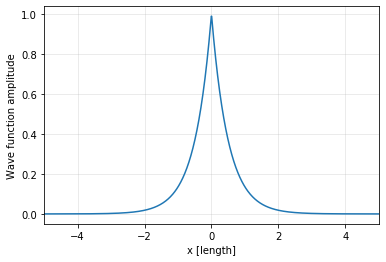

In [3]:
#Plotting
x = np.linspace(-5,5,1000)
y = 0
z = 0
r = np.sqrt(x**2 + y**2 + z**2)
#Take y = 0 and z = 0 and see for which value lambda in x is a good approx for inf
fig, ax = plt.subplots()
ax.plot(x,np.exp(-2*r))
ax.set_xlim(-5,5)
ax.grid(alpha=0.3)
ax.set_xlabel("x [length]")
ax.set_ylabel("Wave function amplitude")
plt.savefig("WavefunctionAmp.png",format="png",dpi=300)
plt.show()

From this we conclude that $\lambda = 3$ is a good approximation for $\infty$. As the wave function is axisymmetric this is the approximation for x, y and z.

**Let's now calculate the integral using GQ with Legendre polynomials for a few different number of integration points.**

In [321]:
#N = [2,3,4,5,6]
#N = [2,4,6,10,15,20,25,30]
N = [5,7,11,17,23,25,31,33]
IntegralTotal = np.zeros(int(len(N)))
counter = 0
for n in N:
    intPoints, weights = GaussLegendre(n)
    Integral = GaussLegendreWaveFunc(n,WaveFunctionPos,-4,4,intPoints,weights)
    IntegralTotal[counter] = Integral
    counter += 1

**Now we plot the results:**

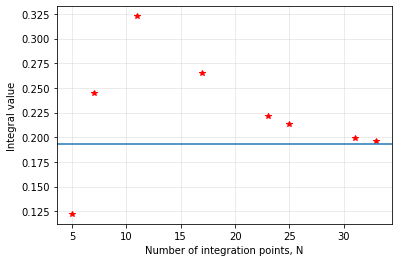

In [295]:
fig2, ax2 = plt.subplots()
ax2.plot(N,IntegralTotal,'r*')
ax2.axhline(y=5*np.pi**2/(16**2))
ax2.grid(alpha=0.3)
ax2.set_xlabel("Number of integration points, N")
ax2.set_ylabel("Integral value")
plt.show()

**Calculating the error:**

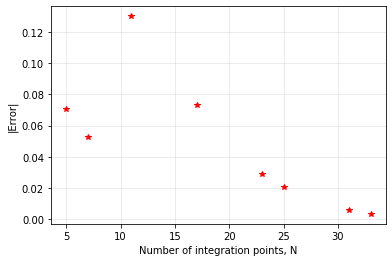

In [296]:
AnalyticalValue = 5*np.pi**2/(16**2)
ErrorGaussQuad = AnalyticalValue - IntegralTotal
fig3,ax3 = plt.subplots()
ax3.plot(N,abs(ErrorGaussQuad),'r*')
ax3.grid(alpha=0.3)
ax3.set_ylabel("|Error|")
ax3.set_xlabel("Number of integration points, N")
plt.show()

## Improved Gauss Quadrature

**We now change to spherical coordinates and integrate over a sphere. Our variables are then:**

$\theta \in [0,\pi]$.  
$\phi \in [0,2\pi]$  
$r \in [0,\infty)$  

We then use Laguerre polynomials for the radial part, $r$, and Legendre polynomials for the angle parts, $\theta$ and $\phi$.

Using the Laguerre polynomials we absorbe the exponential into the weight function.

Our integral now reads

$$I = \int_{0}^{\infty}r_1^2dr_1 \int_{0}^{\infty}r_2^2dr_2 \int_{0}^{2\pi}d\phi_1 \int_{0}^{2\pi}d\phi_2 \int_{0}^{\pi}sin(\theta_1)d\theta_1 \int_{0}^{\pi}sin(\theta_2)d\theta_2 \frac{e^{-2\alpha(r_1 + r_2)}}{r_{12}} $$

where 

$$\frac{1}{r_{12}}= \frac{1}{\sqrt{r_1^2+r_2^2-2r_1r_2cos(\beta)}}$$

and

$$cos(\beta) = cos(\theta_1)cos(\theta_2)+sin(\theta_1)sin(\theta_2)cos(\phi_1-\phi_2))$$

Then we can absorbe the exponential wave functions into the weights utilizing Laguerre polynomials.

**Now we take measurements for the same values of integration points, N, as before but using the improved GQ with Legendre for the angles and Laguerre for the radial part:**

In [322]:
n = [5,7,11,17,23,25,31,33]
IntegralTotal2 = np.zeros(len(n))
counter = 0
for N in n:
    #setting up integration limits and integration points and weights
    aTheta = 0
    bTheta = np.pi
    aPhi = 0
    bPhi = 2*np.pi
    #theta
    intPointsTheta, weightsTheta = GaussLegendre(N)
    intPointsTheta = ((bTheta-aTheta)/2)*intPointsTheta + (bTheta+aTheta)/2
    #print(intPointsTheta)
    #Phi
    intPointsPhi, weightsPhi = GaussLegendre(N)
    intPointsPhi = ((bPhi-aPhi)/2)*intPointsPhi + (bPhi+aPhi)/2
    #print(intPointsPhi)
    #R
    intPointsR = LaguerreRoots(N)
    weightsR = LaguerreWeights(intPointsR,N)
    #print(intPointsR)
    #print(weightsR)

    #Result
    Integral2 = ImprovedGauss(N,WaveFuncPolar,intPointsTheta,intPointsPhi,intPointsR,weightsTheta,weightsPhi,weightsR,aTheta,bTheta,aPhi,bPhi)
    IntegralTotal2[counter] = Integral2
    counter += 1

**Plotting the results:**

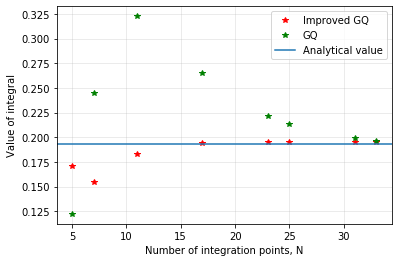

In [299]:
fig3,ax3 = plt.subplots()
ax3.plot(n,IntegralTotal2,'r*',label="Improved GQ")
ax3.plot(n,IntegralTotal,'g*',label="GQ")
ax3.axhline(y=5*np.pi**2/(16**2),label="Analytical value")
ax3.grid(alpha=0.3)
ax3.set_xlabel("Number of integration points, N")
ax3.set_ylabel("Value of integral")
ax3.legend()
plt.savefig("GQandImprovedGQ.png",format="PNG",dpi=300)
plt.show()

**Printing out the values:**

In [300]:
print(n)
print("GQ: ",IntegralTotal)
print("Improved GQ: ",IntegralTotal2)

[5, 7, 11, 17, 23, 25, 31, 33]
GQ:  [0.12220851 0.24536729 0.32274001 0.26564817 0.22177484 0.21336473
 0.19887355 0.19627595]
Improved GQ:  [0.17049197 0.15442207 0.18302187 0.19439573 0.19481241 0.19480424
 0.19477176 0.19475479]


**Calculating and plotting the error:**

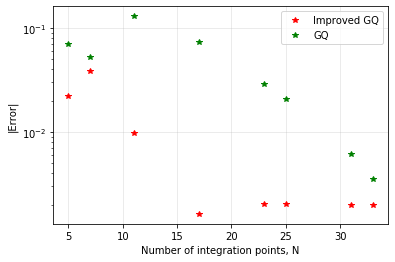

In [319]:
AnalyticalValue = 5*np.pi**2/(16**2)
ErrorGaussQuad = AnalyticalValue - IntegralTotal
ErrorGaussQuadImproved = AnalyticalValue - IntegralTotal2
fig5,ax5 = plt.subplots()
ax5.plot(n,abs(ErrorGaussQuadImproved),'r*',label="Improved GQ")
ax5.plot(n,abs(ErrorGaussQuad),'g*',label="GQ")
ax5.grid(alpha=0.3)
ax5.set_ylabel("|Error|")
ax5.set_xlabel("Number of integration points, N")
plt.yscale("log")
ax5.legend(loc="upper right")
plt.savefig("GaussQuadError.png",format="PNG",dpi=300)
plt.show()

**Print the error:**

In [302]:
print("GQ: ",abs(ErrorGaussQuad))
print("Improved GQ: ",abs(ErrorGaussQuadImproved))

GQ:  [0.0705572  0.05260158 0.1299743  0.07288246 0.02900913 0.02059902
 0.00610784 0.00351024]
Improved GQ:  [0.02227374 0.03834364 0.00974385 0.00163002 0.0020467  0.00203852
 0.00200605 0.00198908]


# Monte Carlo Methods:

**Now we start implementing Monte Carlo Methods: First we use a brute force approach and integrate in cartesian coordinates.**

In [251]:
#random number generator
@jit(nopython=True)
def MonteCarloInt(N,a,b):
    functionValue = 0
    Sigma_contr = 0
    #calculating Jacobi determinant
    JBdeter = (b-a)**6
    #N - number of iterations, takes in a function on an interval [a,b]
    for i in range(N):
        #generating random numbers using numpy on [0,1) and the use a mapping to project onto [a,b]
        randx1 = np.random.random()
        randx1 = a + (b-a)*randx1
        randx2 = np.random.random()
        randx2 = a + (b-a)*randx2
        randy1 = np.random.random()
        randy1 = a + (b-a)*randy1
        randy2 = np.random.random()
        randy2 = a + (b-a)*randy2
        randz1 = np.random.random()
        randz1 = a + (b-a)*randz1
        randz2 = np.random.random()
        randz2 = a + (b-a)*randz2
        #contribution to function value
        funcTemp = WaveFunctionPos(randx1,randy1,randz1,randx2,randy2,randz2)
        functionValue += funcTemp
        #contribution to variance and std
        Sigma_contr += funcTemp**2
        
    #Average value
    Integral = functionValue/N
    sum2 = Integral
    Integral = Integral*JBdeter
    #Variance
    Sigma_contr = Sigma_contr/N
    sum2 = sum2/N
    Variance = (JBdeter**2)*((Sigma_contr - sum2**2)/N)
    #Standard Deviation
    StandardDev = np.sqrt(Variance)
    return Integral, Variance, StandardDev

In [249]:
#Sampling for different number of iterations
M = [1000,10e3,10e4,10e5,10e6,10e7]
Integral3 = np.zeros(len(M))
Variance3 = np.zeros(len(M))
StandardDev3 = np.zeros(len(M))
Timer3 = np.zeros(len(M))
counter = 0
for N in M:
    start = time.time()#Timing each run
    Integral3temp, Variance3temp, StandardDev3temp = MonteCarloInt(N,-3,3)
    end = time.time()
    Timer3[counter] = end-start
    Integral3[counter] = Integral3temp
    Variance3[counter] = Variance3temp
    StandardDev3[counter] = StandardDev3temp
    counter += 1

## Monte Carlo with importance sampling:

**We now cast our problem onto spherical cordinates and use the fact that we have an exponential term in our integrand:**

For this we use the exponential distribution

In [303]:
@jit(nopython=True)
def MonteCarloIntImproved(N,aTheta,bTheta,aPhi,bPhi):
    functionValue = 0
    SigmaContr = 0
    #calculating Jacobi determinant
    JBdeter = ((bTheta-aTheta)**2)*((bPhi-aPhi)**2)
    #N - number of iterations, takes in a function on an interval [a,b]
    for i in range(N):
        #generating random numbers using numpy on [0,1) for the angles and mapping to interval [a,b]
        randTheta1 = np.random.random()
        randTheta1 = aTheta + (bTheta-aTheta)*randTheta1
        randTheta2 = np.random.random()
        randTheta2 = aTheta + (bTheta-aTheta)*randTheta2
        randPhi1 = np.random.random()
        randPhi1 = aPhi + (bPhi-aPhi)*randPhi1
        randPhi2 = np.random.random()
        randPhi2 = aPhi + (bPhi-aPhi)*randPhi2
        #generating random numbers using numpy with the exponential PDF on an interval [0,inf) for the radial part
        randr1 = np.random.exponential(scale=1.0)
        randr2 = np.random.exponential(scale=1.0)
        #Function value
        FuncTemp = WaveFuncPolarMC(randr1,randr2,randTheta1,randTheta2,randPhi1,randPhi2)
        functionValue += FuncTemp
        #Variance
        SigmaContr += FuncTemp**2
    
    #Average value
    Integral = functionValue/N
    sum2 = Integral
    #SigmaTemp = Integral
    Integral = Integral*JBdeter
    #Variance
    SigmaContr = SigmaContr/N
    sum2 = sum2/N
    Variance = (JBdeter**2)*((SigmaContr - sum2**2)/N)
    #Standard Deviation
    StandardDev = np.sqrt(Variance)

    return Integral, Variance, StandardDev

**Calculating the result using MC with importance sampling:**

In [257]:
#Sampling for different number of iterations
M = [1000,10e3,10e4,10e5,10e6,10e7]
Integral5 = np.zeros(len(M))
Variance5 = np.zeros(len(M))
StandardDev5 = np.zeros(len(M))
Timer5 = np.zeros(len(M))
counter = 0
for N in M:
    start = time.time()
    Integral5temp, Variance5temp, StandardDev5temp = MonteCarloIntImproved(N,0,np.pi,0,2*np.pi)
    end = time.time()
    Timer5[counter] = end-start
    Integral5[counter] = Integral5temp
    Variance5[counter] = Variance5temp
    StandardDev5[counter] = StandardDev5temp
    counter += 1

## Improved Monte Carlo with parallelization, Numba:

We now use the fact that the MC method is easily parallilzed and for the we use the package numba

In [304]:
#Function that does the same as the MC function with importance sampling but using parallelization
@jit(nopython=True,parallel=True)
def MonteCarloIntImprovedOpt(N,aTheta,bTheta,aPhi,bPhi,Time):
    N = int(N/4)#to split up between threads
    SigmaContr = 0
    #calculating Jacobi determinant
    JBdeter = ((bTheta-aTheta)**2)*((bPhi-aPhi)**2)
    ThreadNumber = numba.config.NUMBA_DEFAULT_NUM_THREADS#Finding number of threads to split up task
    functionValue = np.zeros(ThreadNumber)
    #N - number of iterations, takes in a function on an interval [a,b]
    for l in prange(ThreadNumber):
        np.random.seed(Time*(l+1))#Seeding differently for each thread if they start at the same time
        for i in range(N):
            #generating random numbers using numpy on [0,1)
            #theta1
            randTheta1 = np.random.random()
            randTheta1 = aTheta + (bTheta-aTheta)*randTheta1
            #theta2
            randTheta2 = np.random.random()
            randTheta2 = aTheta + (bTheta-aTheta)*randTheta2
            #Phi1
            randPhi1 = np.random.random()
            randPhi1 = aPhi + (bPhi-aPhi)*randPhi1
            #Phi2
            randPhi2 = np.random.random()
            randPhi2 = aPhi + (bPhi-aPhi)*randPhi2
            #generating random number using exponential PDF for the radial part
            #r1
            randr1 = np.random.exponential(scale=1.0)
            #r2
            randr2 = np.random.exponential(scale=1.0)
            #function value
            funcTemp = WaveFuncPolarMC(randr1,randr2,randTheta1,randTheta2,randPhi1,randPhi2)
            functionValue[l] += funcTemp
            SigmaContr += funcTemp**2
            
    #Average value
    Integral = np.sum(functionValue)
    sum2 = Integral
    Integral = Integral/(4*N)
    Integral = Integral*JBdeter
    #Variance
    SigmaContr = SigmaContr/(4*N)
    sum2 = sum2/(4*N)
    Variance = (JBdeter**2)*((SigmaContr - sum2**2)/N)
    #Standard Deviation
    StandardDev = np.sqrt(Variance)
    
    return Integral, Variance, StandardDev

In [283]:
#Sampling for the optimezed MonteCarlo with paralellization
Time = time.time()
M = [1000,10e3,10e4,10e5,10e6,10e7]
Integral6 = np.zeros(len(M))
Variance6 = np.zeros(len(M))
StandardDev6 = np.zeros(len(M))
Timer6 = np.zeros(len(M))
counter = 0
for N in M:
    start = time.time()
    Integral6temp, Variance6temp, StandardDev6temp = MonteCarloIntImprovedOpt(N,0,np.pi,0,2*np.pi,Time)
    end = time.time()
    Timer6[counter] = end-start
    Integral6[counter] = Integral6temp
    Variance6[counter] = Variance6temp
    StandardDev6[counter] = StandardDev6temp
    counter += 1

In [284]:
print(Integral6, StandardDev6)
print(AnalyticalValue)

[0.19186693 0.19805423 0.19463211 0.19315981 0.19286329 0.19278904] [0.02325287 0.00788695 0.00265191 0.00081167 0.00025847 0.00008143]
0.19276571095877654


**Plotting brute force Monte Carlo vs Monte Carlo with importance sampling:**

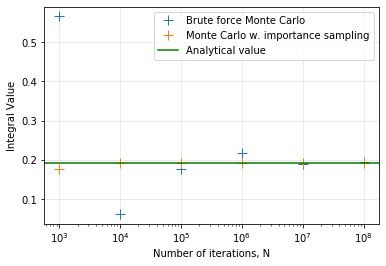

In [315]:
fig6,ax6 = plt.subplots()
ax6.plot(M,Integral3,'+',ms=10,label="Brute force Monte Carlo")
ax6.plot(M,Integral5,'+',ms=10,label="Monte Carlo w. importance sampling")
ax6.axhline(y=5*np.pi**2/(16**2),c='g',label="Analytical value")
ax6.legend()
plt.xscale("log")
ax6.set_xlabel("Number of iterations, N")
ax6.set_ylabel("Integral Value")
ax6.grid(alpha=0.3)
plt.savefig("MonteCarloComparison.png",format="png",dpi=300)

**Print out values:**

In [306]:
np.set_printoptions(suppress=True)
#No importance sampling
print("Brute Force: ",Integral3)
print("Brute Force: ",StandardDev3)
#Importance sampling
print("Importance Sampling", Integral5)
print("Importance Sampling", StandardDev5)
print(10**2)

Brute Force:  [0.56497764 0.06170277 0.1758335  0.21646774 0.18991891 0.19546554]
Brute Force:  [0.32011648 0.01571785 0.05947085 0.03018525 0.00809075 0.00392256]
Importance Sampling [0.17618565 0.19259224 0.19184081 0.19300942 0.19256837 0.19275255]
Importance Sampling [0.01275696 0.00445128 0.00142621 0.00045608 0.00014205 0.00004514]
100


**Calculating Error against anaytical value:**

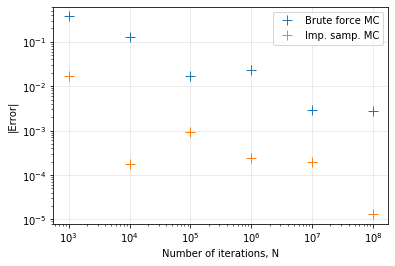

In [316]:
ErrorBruteMC = AnalyticalValue - Integral3
ErrorMCImportance = AnalyticalValue - Integral5
#plotting
fig7,ax7 = plt.subplots()
ax7.plot(M,abs(ErrorBruteMC),'+',ms=10,label="Brute force MC")
ax7.plot(M,abs(ErrorMCImportance),'+',ms=10,label="Imp. samp. MC")
plt.xscale("log")
plt.yscale("log")
ax7.grid(alpha=0.3)
ax7.legend()
ax7.set_ylabel("|Error|")
ax7.set_xlabel("Number of iterations, N")
plt.savefig("MC_comparison_error.png",format="PNG",dpi=300)

**Looking at time difference for parallelization vs no parallelization:**

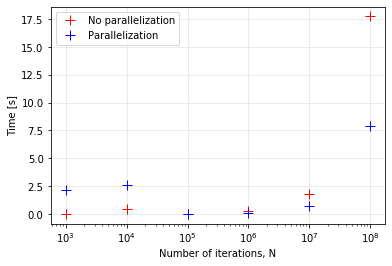

In [320]:
fig8, ax8 = plt.subplots()
ax8.plot(M,Timer5,'r+',ms=10,label="No parallelization")
ax8.plot(M,Timer6,'b+',ms=10,label="Parallelization")
plt.xscale("log")
ax8.grid(alpha=0.3)
ax8.set_xlabel("Number of iterations, N")
ax8.set_ylabel("Time [s]")
ax8.legend()
plt.savefig("TimeComparison.png",format="PNG",dpi=300)
plt.show()